In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from astropy.timeseries import LombScargle
import scipy.optimize

#change title based on MPC target
#title = '20210305_2015BY310'
title = '20221003_A10KEDv'
#title = '20220919_C35GV51'
#title = '20220919_C35HW61'
#title = '20220919_C35LVC1'
exposure_time = 1

#comment all below (except phot_cal) when re-running this
#os.mkdir(title)
#os.rename(title + '_cal.txt', title + '/' + title + '_cal.txt')

#leave this line uncommented
phot_cal = np.loadtxt(title + '/' + title + '_cal.txt')

#for j in range(len(phot_cal)):
     #os.rename(title + '_phot_curve_' + str(j+1) + '.txt', title + '/' + title + '_phot_curve_' + str(j+1) + '.txt') 

c:\Users\larry\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
#binning function
def bin(arr1,arr2,arr3):
    #change as necessary, longer observations -> more bins
    num_bins = 30
    #sets bins
    array = pd.cut(arr1,bins=num_bins,retbins=True)
    #gets indices of data in each bin
    bins_index = []
    for i in range(num_bins):
        tempArr = []
        for j in range(len(arr1)):
            if array[1][i] <= arr1[j] <= array[1][i+1]: 
                tempArr.append(j)    
        bins_index.append(tempArr)
    #within each bin, take the average Frame and rel_flux values
    means = []
    for i in range(num_bins):
        tempArr = []
        tempArr.append(np.mean(arr1[bins_index[i][0]:bins_index[i][-1]+1]))
        tempArr.append(np.mean(arr2[bins_index[i][0]:bins_index[i][-1]+1]))
        tempArr.append(np.mean(arr3[bins_index[i][0]:bins_index[i][-1]+1]))
        #change based on num of target stars

        means.append(tempArr)
    means = np.transpose(means)
    #rows go by Time, Flux, Mags
    return means
#sine fit function
def fit_sin(tt, yy, freq_guess):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])
    guess_freq = freq_guess
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}


<ipython-input-3-9206003ec952>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Flux'][i] = float(df['Flux'][i])


Stats for dataset 1:
mean: 17.564777791228938, stdev: 0.09783525308563963
period is likely around 47.46031746031746s with power 0.19637136090401322
Amplitude=0.06129685919755714, freq.=0.02110225574845936, period=47.38829876388965, offset=17.56039219436258, Max. Cov.=0.05733115555439266




<ipython-input-3-9206003ec952>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Flux'][i] = float(df['Flux'][i])


Stats for dataset 2:
mean: 17.512481136124425, stdev: 0.08300873747008196
period is likely around 46.0s with power 0.09582173827456159
Amplitude=0.03717887658218446, freq.=0.021437568416847, period=46.64708144857216, offset=17.512063439101155, Max. Cov.=0.12740838950514174




<ipython-input-3-9206003ec952>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Flux'][i] = float(df['Flux'][i])


Stats for dataset 3:
mean: 17.416350765608822, stdev: 0.11956532470562023
period is likely around 47.46031746031746s with power 0.11816275440616156
Amplitude=-0.05777500746547285, freq.=0.02110706600354486, period=47.37749907220897, offset=17.419379741607738, Max. Cov.=0.10563419637582791




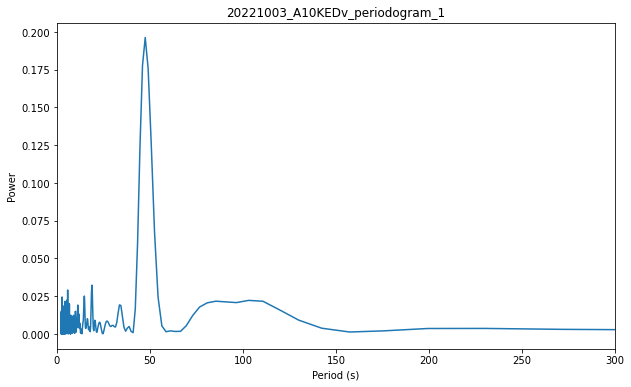

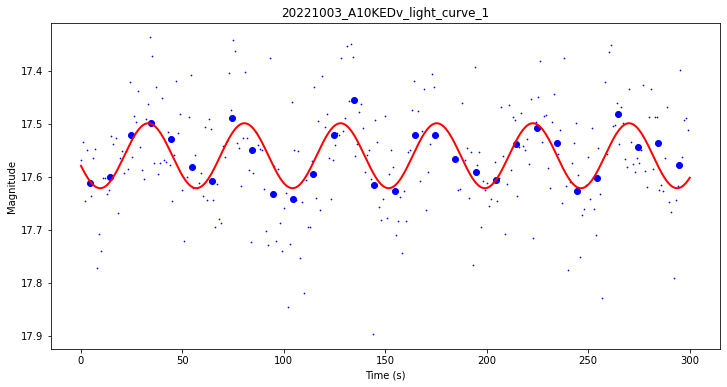

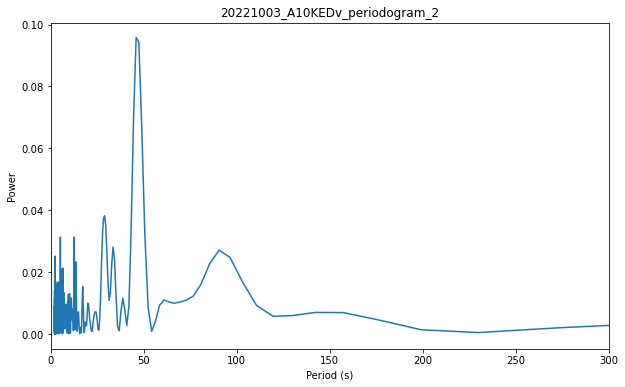

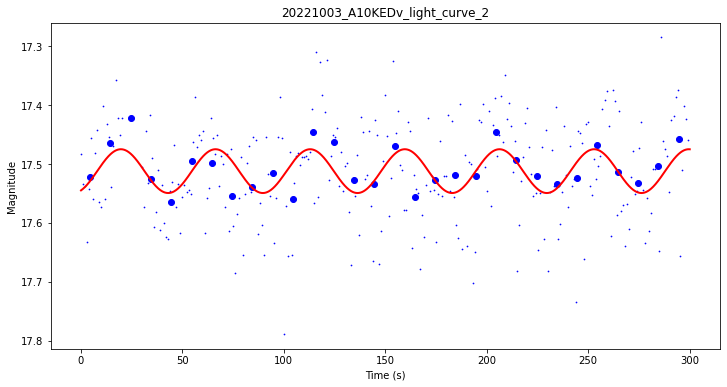

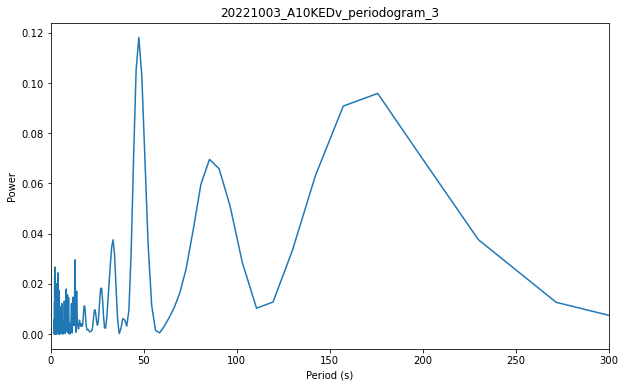

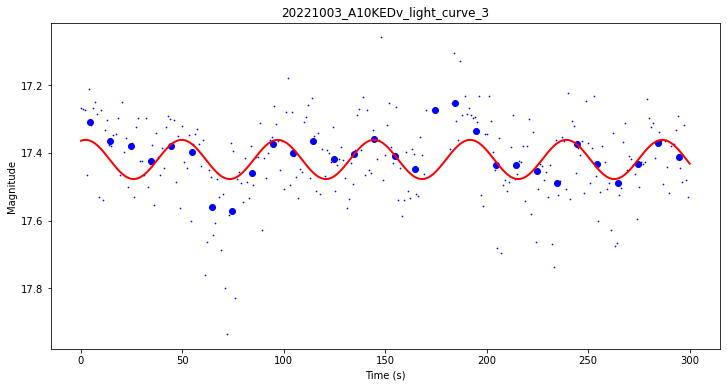

In [3]:
#plotting and statistics, repeat for each dataset
for j in range(len(phot_cal)):
    #read photometry file
    df = pd.read_csv(title + '/' + title + '_phot_curve_' + str(j+1) + '.txt',header=None,names=['Flux'])

    df['Time'] =list(range(0,len(df)*exposure_time,exposure_time))
    for i in range(len(df)):
        df['Flux'][i] = float(df['Flux'][i])
    mags = []
    mags_sub = []
    #magnitude calculation
    for i in range(len(df)):
        if df['Flux'][i] > 0:
            mags.append(15 - 2.5*math.log10(df['Flux'][i]/1800) + phot_cal[j])
            mags_sub.append(15 - 2.5*math.log10(df['Flux'][i]/1800) + phot_cal[j])
        else:  
            mags.append(np.nan)
    df['Mags'] = mags
    print('Stats for dataset ' + str(j+1) + ':')
    print('mean: ' + str(np.mean(mags_sub)) + ', stdev: ' + str(np.std(mags_sub)))

    #create periodogram
    means = bin(df['Time'],df['Flux'],df['Mags'])
    time1 = []
    mags1 = []
    for i in range(len(df)):
        if (np.isnan(df['Mags'][i])):
            continue
        else:
            time1.append(df['Time'][i])
            mags1.append(df['Mags'][i])
    #LombScargle periodogram
    frequency, power = LombScargle(time1,mags1).autopower(nyquist_factor=1)
    period = []
    for i in range(len(frequency)):
        if (frequency[i] > 0):
            period.append(1/frequency[i])
        #else:
            #period.append(np.nan)
    #plot periodogram
    plt.figure(figsize=(10,6))
    plt.xlim(0,300)
    plt.xlabel('Period (s)')
    plt.ylabel('Power')
    plt.plot(period,power)
    plt.title(title + '_periodogram_' + str(j+1))
    plt.savefig(title + '/' + title + '_periodogram_' + str(j+1) + '.jpg')
    max_index = np.argmax(power)
    print('period is likely around ' + str(period[max_index]) + 's with power ' + str(power[max_index]))

    #sine fit curve
    res = fit_sin(time1,mags1,1/period[max_index])
    print( "Amplitude=%(amp)s, freq.=%(freq)s, period=%(period)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )
    print('\n')
    tt2 = np.linspace(0,len(df)*exposure_time,100*len(df)*exposure_time)
    
    # plot with binning nearest magnitudes
    # plt.figure(figsize=(12,6))
    # plt.plot(tt2, res["fitfunc"](tt2), "r-", linewidth=2)
    # plt.scatter(df['Time'],df['Mags'],s=0.5,c="blue")
    # plt.scatter(means[0], means[2],c="blue")
    # plt.title(title)
    # plt.ylabel('Magnitude')
    # plt.xlabel('Time')
    # plt.gca().invert_yaxis()
    

    #plot with binning nearest flux, then converting into magnitudes
    mag_mean = []
    for i in range(len(means[1])):
        if means[1][i] > 0:
            mag_mean.append(15 - 2.5*math.log10(means[1][i]/1800) + phot_cal[j])
        else:
            mag_mean.append(np.nan)
    plt.figure(figsize=(12,6))
    plt.plot(tt2, res["fitfunc"](tt2), "r-", linewidth=2)
    plt.scatter(df['Time'],df['Mags'],s=0.5,c="blue")
    plt.scatter(means[0], mag_mean,c="blue")
    plt.title(title + '_light_curve_' + str(j+1))
    plt.gca().invert_yaxis()
    plt.ylabel('Magnitude')
    plt.xlabel('Time (s)')
    plt.savefig(title + '/' + title + '_light_curve_' + str(j+1) + '.jpg')

